In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Hands-On Predictive Analysis with Python Workshop/Week 2 - Project/Housing Prices- Advanced Regression Techniques

/content/gdrive/MyDrive/Colab Notebooks/Hands-On Predictive Analysis with Python Workshop/Week 2 - Project/Housing Prices- Advanced Regression Techniques


In [ ]:
import numpy as np
import pandas as pd
import pandas.api.types as p_types
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Import the dataset

In [ ]:
houses_train = pd.read_csv('train.csv')
print('Training data set size: {}'.format(houses_train.shape))

houses_test = pd.read_csv('test.csv')
test_Id = houses_test['Id']
print('Test data set size: {}'.format(houses_test.shape))

#concatenate (row wise) the data frames so that if any features are dropped/modified, it's done from both.
#by default, axis=0; so the concatenation, here, is row-wise
houses = pd.concat([houses_train, houses_test])
houses.drop('Id', axis=1, inplace=True)

Training data set size: (1460, 81)
Test data set size: (1459, 80)


#NULL VALUE HANDLING

In [ ]:
#dictionary of features that have null values (at least one)
null_features = {feature : count for feature,count in dict(houses.isna().sum()).items() if count}
del null_features['SalePrice']
null_features

{'Alley': 2721,
 'BsmtCond': 82,
 'BsmtExposure': 82,
 'BsmtFinSF1': 1,
 'BsmtFinSF2': 1,
 'BsmtFinType1': 79,
 'BsmtFinType2': 80,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'BsmtQual': 81,
 'BsmtUnfSF': 1,
 'Electrical': 1,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'Fence': 2348,
 'FireplaceQu': 1420,
 'Functional': 2,
 'GarageArea': 1,
 'GarageCars': 1,
 'GarageCond': 159,
 'GarageFinish': 159,
 'GarageQual': 159,
 'GarageType': 157,
 'GarageYrBlt': 159,
 'KitchenQual': 1,
 'LotFrontage': 486,
 'MSZoning': 4,
 'MasVnrArea': 23,
 'MasVnrType': 24,
 'MiscFeature': 2814,
 'PoolQC': 2909,
 'SaleType': 1,
 'TotalBsmtSF': 1,
 'Utilities': 2}

##Drop columns 

In [ ]:
#with 'too many' (>=80%) null values
drop_features = [feature for feature, count in null_features.items() if int(count/houses.shape[0]*100) >= 80]
houses.drop(drop_features, axis = 1, inplace=True)

#UPDATE the 'null_features' dictionary
for f in drop_features:
  null_features.pop(f, None)

#display the updated null_features (to know what values to fill them up with)
null_features

{'BsmtCond': 82,
 'BsmtExposure': 82,
 'BsmtFinSF1': 1,
 'BsmtFinSF2': 1,
 'BsmtFinType1': 79,
 'BsmtFinType2': 80,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'BsmtQual': 81,
 'BsmtUnfSF': 1,
 'Electrical': 1,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'FireplaceQu': 1420,
 'Functional': 2,
 'GarageArea': 1,
 'GarageCars': 1,
 'GarageCond': 159,
 'GarageFinish': 159,
 'GarageQual': 159,
 'GarageType': 157,
 'GarageYrBlt': 159,
 'KitchenQual': 1,
 'LotFrontage': 486,
 'MSZoning': 4,
 'MasVnrArea': 23,
 'MasVnrType': 24,
 'SaleType': 1,
 'TotalBsmtSF': 1,
 'Utilities': 2}

##Null value imputation...
* With 'None' and 0

In [ ]:

#Here, we select few features whose null value, we reason, it's best to replace with 'None' (for object data type) or 0 (for numeric data type)

#this is merely to make the imputation (with 'None' and 0) a more compact code
impute_keywords = ['Bsmt', 'Garage', 'MasVnr']
def to_impute(feature):
  for k in impute_keywords:
    if k in feature:
      return True      
  return False

#list of features that need to be imputed with the value 'None'
none_impute = [feature for feature in null_features.keys() if houses[feature].dtype == 'object' and to_impute(feature)]
none_impute.append('FireplaceQu')

#fill those values in the dataset inplace
houses.update(houses[none_impute].fillna('None'))

#list of features that we impute with value 0
zero_impute = [feature for feature in null_features.keys() if p_types.is_numeric_dtype(houses[feature]) and to_impute(feature)]
houses.update(houses[zero_impute].fillna(0))

In [ ]:
#again display the remaining features with null values
null_features = {feature : count for feature,count in dict(houses.isna().sum()).items() if count}
del null_features['SalePrice']
null_features

{'Electrical': 1,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'Functional': 2,
 'KitchenQual': 1,
 'LotFrontage': 486,
 'MSZoning': 4,
 'SaleType': 1,
 'Utilities': 2}

* Further analysis to decide on the appropriate value to use for imputation (here, we perform manual imputation).
* Sometimes this analysis can lead us to drop a few column(s) (as in the case of *Utilities*).

In [ ]:
#Some analysis needs to be done on these features based on the data_description.txt given and the range of values they take
houses['Utilities'].value_counts() 

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [ ]:
#The variance in this feature is too less to be of any significance to our model. So, drop it!
houses.drop('Utilities', axis=1, inplace=True)

In [ ]:
#The null values of the remaining features are filled with logically determined values

#The following features are assumed to depend on the Neighborhood. 
#Mean value for numeric data types and the most frequent value (mode) for categorical features
houses['LotFrontage'] = houses.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

for feature in ['MSZoning', 'Electrical']:
    houses[feature] = houses.groupby('Neighborhood')[feature].transform(lambda x: x.fillna(x.mode()[0]))

#Only one missing value, so we fill it with the most frequent value
for field in ['SaleType','Exterior1st','Exterior2nd',]:
    houses[field].fillna(houses[field].mode()[0],inplace=True)

#For both these features we assume they are typical types
houses['Functional'].fillna('Typ',inplace=True)
houses['KitchenQual'].fillna('TA',inplace=True)


#ENCODING

In [ ]:
#get the type of each feature... It's useful when we want to know what encoding to perform on each feature
feature_types = {typ.name: feature for typ, feature in houses.columns.to_series().groupby(houses.dtypes).groups.items()}
print(feature_types)

{'int64': Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object'), 'float64': Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'SalePrice'],
      dtype='object'), 'object': Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFi

##Label Encoding
* Compute the range of values that integer type features assume. Based on the range we can at times make an intelligent guess which features may need LabelEncoding. Values within a narrow range are typically used for classification (given that we are dealing with **integer** types)

* Yes! Even integer type features can need encoding when only the relative ordering of the numbers is important (as in *YrSold*, for example) and not the exact value of the number per se

In [ ]:
{f: (houses[f].min(), houses[f].max()) for f in feature_types['int64']}

{'1stFlrSF': (334, 5095),
 '2ndFlrSF': (0, 2065),
 '3SsnPorch': (0, 508),
 'BedroomAbvGr': (0, 8),
 'EnclosedPorch': (0, 1012),
 'Fireplaces': (0, 4),
 'FullBath': (0, 4),
 'GrLivArea': (334, 5642),
 'HalfBath': (0, 2),
 'KitchenAbvGr': (0, 3),
 'LotArea': (1300, 215245),
 'LowQualFinSF': (0, 1064),
 'MSSubClass': (20, 190),
 'MiscVal': (0, 17000),
 'MoSold': (1, 12),
 'OpenPorchSF': (0, 742),
 'OverallCond': (1, 9),
 'OverallQual': (1, 10),
 'PoolArea': (0, 800),
 'ScreenPorch': (0, 576),
 'TotRmsAbvGrd': (2, 15),
 'WoodDeckSF': (0, 1424),
 'YearBuilt': (1872, 2010),
 'YearRemodAdd': (1950, 2010),
 'YrSold': (2006, 2010)}

* With integer type variables the LabelEncoding is natural.

* With object type (i.e., string type), ideally, we need to order the categories a feature assumes (I mean, those features that have some sense of ordering in the values they assume (for example, *LandSlope*)). They need to be OrdinalEncoded, i.e., an explicit order needs to be mentioned.

* Note that LabelEncoder orders the values of strings lexicographically. 

* So, a careful analysis of the values of the object type features may indicate that there could be a few features for which an explicit order need not be mentioned because their value labels are such that they are already lexicographically sorted! (See, for example, *LandSlope* shown below (the count is not important for the sorting I'm describing here!))

In [ ]:
houses.groupby('LandSlope')['LandSlope'].count()
#same as: 
#houses['LandSlope'].value_counts()

LandSlope
Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64

* After performing all that analysis, thereby determining the features necessary, we (finally!) perform the LabelEncoding

In [ ]:
labelencoder_features = ['MSSubClass','LandSlope','YearBuilt','YearRemodAdd','CentralAir','GarageYrBlt','PavedDrive','YrSold']

for f in labelencoder_features:
    houses[f] = LabelEncoder().fit_transform(houses[f].values)

##Ordinal Encoding

* Specify the features to be OrdinalEncoded and the orders

In [ ]:
ordinalencoder_features = ['ExterQual','LotShape','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',\
                           'BsmtFinType2','HeatingQC', 'Functional','FireplaceQu','KitchenQual', 'GarageFinish',\
                           'GarageQual','GarageCond']

#very important...else the OrdinalEncoding just won't work
for f in ordinalencoder_features:
  houses[f] = houses[f].astype(str)

orders=[
    #ExterQual
    ['Po','Fa','TA','Gd','Ex'],
    #LotShape
    ['Reg','IR1' ,'IR2','IR3'],
    #BsmtQual
    ['None','Fa','TA','Gd','Ex'],
    #BsmtCond
    ['None','Po','Fa','TA','Gd','Ex'],
    #BsmtExposure
    ['None','No','Mn','Av','Gd'],
    #BsmtFinType1
    ['None','Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ'],
    #BsmtFinType2
    ['None','Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ'],
    #HeatingQC
    ['Po','Fa','TA','Gd','Ex'],
    #Functional
    ['Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
    #FireplaceQu
    ['None','Po','Fa','TA','Gd','Ex'],
    #KitchenQual
    ['Fa','TA','Gd','Ex'],
    #GarageFinish
    ['None','Unf','RFn','Fin'],
    #GarageQual
    ['None','Po','Fa','TA','Gd','Ex'],
    #GarageCond
    ['None','Po','Fa','TA','Gd','Ex'] ]
   

# ordinal features with specific order...
for i in range(len(orders)):
  houses[ordinalencoder_features[i]] = OrdinalEncoder(categories = {0:orders[i]}).fit_transform(\
                                                                                  houses[ordinalencoder_features[i]].values.reshape(-1,1))
  #reshape converts the 1-d array returned by values to a 2-d one.
  #OrdinalEncoder's fit() accepts only 2-d arguments (note that fit(underscore)transform implies that first fit(), then transform() is performed)

##One-hot encoding

In [ ]:
#get_dummies() one-hot encodes those features that are categorical
#Each feature is expanded to a number of columns equal to the number of categories assumed by the feature
houses = pd.get_dummies(houses)

#OUTLIERS
* Now, only finding Outliers (if any) is left (among the preprocessing steps, I mean).

* Removing outliers implies removing rows... So we need to check for them **only in the train dataset**

* We now split the concatenated frame into train and test datasets respectively

In [ ]:
houses_train = houses[:houses_train.shape[0]]
print(houses_train.shape)

houses_test = houses[houses_train.shape[0]:].drop('SalePrice', axis=1)
print(houses_test.shape)

(1460, 218)
(1459, 217)


* From the SPECIAL NOTES section in [Data documentation with additional notes](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), we are given to understand that there are a few outliers present in the data. 

* To quote:
" *I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations)* " 

* We can manually remove the mentioned outliers or perform some additional computation to find more outliers. Here we remove manually.


In [ ]:
outliers = np.where(houses_train['GrLivArea']>4000)[0]
houses_train = houses_train.drop(outliers)

#REGRESSION

* We transform the distribution of the target variable to a Gaussian one (at least, similar to one) by taking its log

In [ ]:
X = houses_train.drop('SalePrice', axis=1).values #note that we are not dropping inplace
y = np.log1p(houses_train['SalePrice']) #accurate for small values of y ALSO

results = {}

In [ ]:
def regression(regressor, X=X, y=y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  se = np.array(y_test - y_pred)**2
  return se.mean()
  

## Display the mean square errors

* Multi Linear Regression

In [ ]:
lr = LinearRegression()
results['Linear'] = regression(lr)
print('Linear:', results['Linear'])

Linear: 0.011839780318710986


* Polynomial Regression

In [ ]:
#using a degree 2 polynomial (since for degree = 3, the session is CRASHING!!)
p_lr = LinearRegression()
results['Poly'] = regression(p_lr, PolynomialFeatures(degree = 2).fit_transform(X))
print('Poly:', results['Poly'])

Poly: 0.37463722204445776


* Decision Tree Regression

In [ ]:
dtr = DecisionTreeRegressor()
results['Decision Tree'] = regression(dtr)
print('Decision Tree:', results['Decision Tree'])

Decision Tree: 0.03057176747167466


* Random Forest Regression

In [ ]:
rf = RandomForestRegressor()
results['Random Forest (all features)'] = regression(rf)
print('Random Forest (all features):', results['Random Forest (all features)'])

houses_train_features = list(houses_train.columns)
houses_train_features.remove('SalePrice')

feature_importances = rf.feature_importances_[rf.feature_importances_ > np.percentile(rf.feature_importances_, 90)]
important_features = [houses_train_features[np.where(rf.feature_importances_ == f_i)[0][0]] for f_i in feature_importances]

X_imp = houses_train.loc[:, important_features].values
rf_imp = RandomForestRegressor()
results['Random Forest (important features)'] = regression(rf_imp, X_imp)
print('\nRandom Forest (important features):', results['Random Forest (important features)'])

Random Forest (all features): 0.014530139835140489

Random Forest (important features): 0.014413066257298886


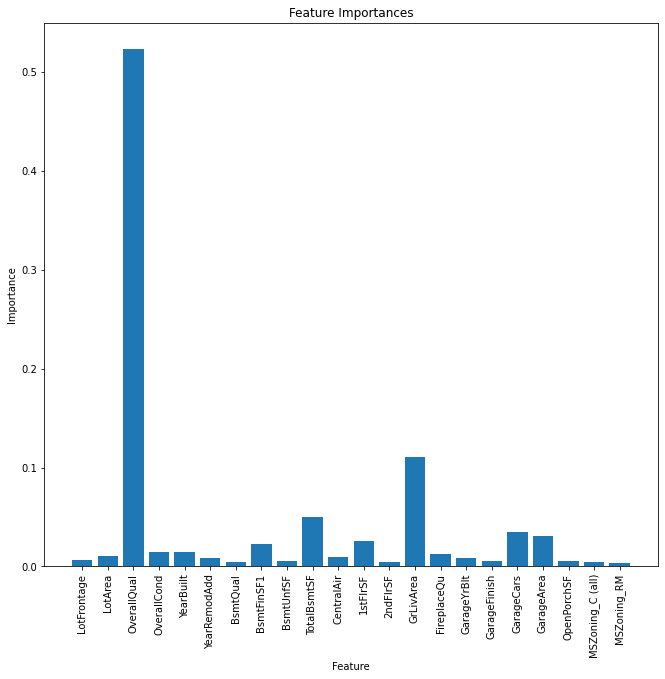

In [ ]:
plt.figure(figsize = (11,10))
x_values = list(range(len(feature_importances)))
plt.bar(x_values, feature_importances, orientation = 'vertical')
plt.xticks(x_values, important_features, rotation='vertical')

plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances');

#TESTING
* Previously we trained only on a part of the training set. Now, we train on the entire training set and predict on the test set

In [ ]:
rf = RandomForestRegressor()
sale_price = rf.fit(X,y)

test = houses_test.values
sale_price = rf.predict(test)

sale_price = np.exp(np.array(sale_price))

In [ ]:
print(sale_price)

[125660.82981578 150754.91526625 184068.52203197 ... 150300.51597941
 117574.80274451 225441.90795901]


##SUBMISSION

In [ ]:
submission = pd.DataFrame(sale_price, columns = ['SalePrice'])
submission = pd.concat([test_Id, submission], axis=1) #columnwise concatenate

submission.head()

,Id,SalePrice
0,1461,125660.829816
1,1462,150754.915266
2,1463,184068.522032
3,1464,180254.776162
4,1465,196292.576486


In [ ]:
submission.to_csv('Housing Prices (Test).csv', index=False)